# Bar Crawl: Detecting Heavy Drinking
--------------------------------------

In [133]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

acc = pd.read_csv('all_accelerometer_data_pids_13.csv')
acc['datetime'] = pd.to_datetime(acc['time'], unit='ms')
acc = acc[acc.time != 0]

In [134]:
# Preparing TAC data
import os

folder = 'clean_tac/'

# Get all files in the folder
files = os.listdir(folder)

# Get all the pids
pids = [str(file.split('_clean_TAC.')[0]) for file in files]

# Get all the TAC readings for each person in a dictionary
tac_dict = {pid: pd.read_csv(folder + str(pid) + '_clean_TAC.csv') for pid in pids}


In [135]:
# Function to get TAC data for a specific person
def get_tac_data(pid):
    return tac_dict[pid]

# Concatenating all the TAC readings into one dataframe, with a pid column
def get_tac_full_data():
    tac_full_data = pd.DataFrame()
    for pid in pids:
        tac_data = get_tac_data(pid)
        tac_data = tac_data.assign(pid=[pid]*len(tac_data))
        tac_full_data = pd.concat([tac_full_data,tac_data])
    return tac_full_data

In [136]:
# Getting the complete TAC data
tac = get_tac_full_data()
tac

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610
...,...,...,...
49,1493797974,0.029049,SF3079
50,1493799820,0.016286,SF3079
51,1493801652,0.004243,SF3079
52,1493803481,-0.001995,SF3079


In [137]:
# Converting the timestamp column to datetime
tac['datetime'] = pd.to_datetime(tac['timestamp'], unit='s')
tac.head(5)

,timestamp,TAC_Reading,pid,datetime
0,1493718714,-0.000482,BK7610,2017-05-02 09:51:54
1,1493720697,0.001573,BK7610,2017-05-02 10:24:57
2,1493721027,0.002144,BK7610,2017-05-02 10:30:27
3,1493721357,0.000877,BK7610,2017-05-02 10:35:57
4,1493721686,-0.001145,BK7610,2017-05-02 10:41:26


In [7]:
# Plotting TAC readings for each person
import plotly.graph_objects as go

fig = go.Figure()

for person in tac['pid'].unique():
    filtered_tac = tac[tac['pid'] == person]
    fig.add_trace(go.Scatter(x=filtered_tac['datetime'], y=filtered_tac['TAC_Reading'], name=person))

# Creating a button to toggle between each person
buttons = []
for person in tac['pid'].unique():
    button = dict(label=person,
                  method='update',
                  args=[{'visible': [person == visible for visible in tac['pid'].unique()]}])
    buttons.append(button)

fig.update_layout(updatemenus=[dict(buttons=buttons)], height=700)

# Display the figure
fig.show()

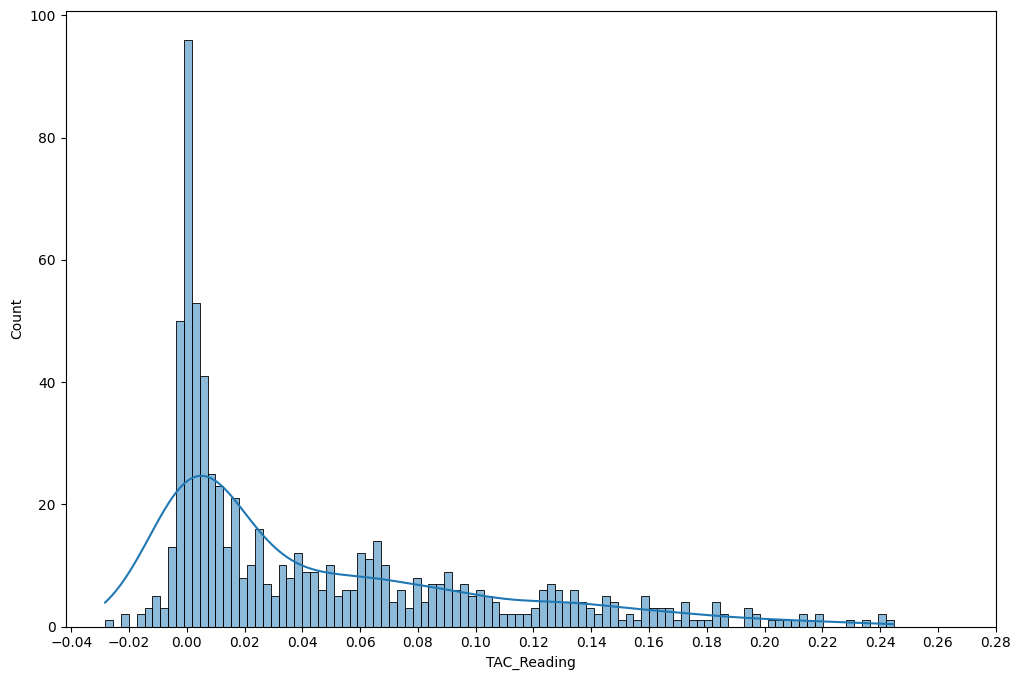

In [8]:
# Plotting histogram of TAC readings before
plt.figure(figsize=(12, 8))
_ = sns.histplot(data=tac, x='TAC_Reading', kde=True, bins=100)
_ = plt.xticks(np.arange(-0.04, 0.3, 0.02))

In [377]:
def resample(dataframe,agg_dict, interval='2s'):
    return dataframe.set_index('datetime').resample(interval).agg(**agg_dict).dropna()

def resample_per_pid(dataframe,agg_dict, interval='2s'):
    return {pid: resample(group,agg_dict, interval) for pid, group in dataframe.groupby('pid')}

def resample_per_pid_concat(dataframe,agg_dict, interval='2s'):
    return pd.concat(resample_per_pid(dataframe, agg_dict, interval))

# perform a lag for time-series data
def lag_columns(df, column_names, lag_period=1):
    for column_name in column_names:
        for i in range(1, lag_period + 1, 1):
            new_column_name = column_name + "_prev" + str(i)
            df[new_column_name] = df[column_name].shift(i)
    return df

def lag_columns_per_pid(dataframe, column_names, lag_period=1):
    return {pid: lag_columns(group, column_names, lag_period) for pid, group in dataframe.groupby('pid')}


In [378]:
agg_dict = {
    'mean_x': ('x', 'mean'), 'mean_y': ('y', 'mean'), 'mean_z': ('z', 'mean')
}
acc_10s = resample_per_pid_concat(acc, agg_dict, '2s')
acc_10s.index.names = ['pid', 'datetime']

In [379]:
acc_10s

mean_x    mean_y    mean_z
pid    datetime                                         
BK7610 2017-05-02 14:37:50  0.069006 -0.004174  0.003128
       2017-05-02 14:37:52  0.004779 -0.000387  0.006020
       2017-05-02 14:37:54  0.003851  0.003256  0.022819
       2017-05-02 14:37:56 -0.000921  0.004732  0.006705
       2017-05-02 14:37:58  0.000524  0.005343  0.006488
...                              ...       ...       ...
SF3079 2017-05-03 05:53:36  0.012184 -0.003641 -0.004531
       2017-05-03 05:53:38  0.005934  0.004356 -0.002704
       2017-05-03 05:53:40  0.004833  0.005594 -0.001099
       2017-05-03 05:53:42  0.008894 -0.004372  0.008570
       2017-05-03 05:53:44 -0.012587  0.071853 -0.017304

[186582 rows x 3 columns]

In [380]:
acc_pid_data = lag_columns_per_pid(acc_10s.reset_index(), ['mean_x', 'mean_y', 'mean_z'], 5)
acc_data = pd.concat(acc_pid_data).dropna().reset_index(drop=True)

In [381]:
def interpolate_tac(tac, interval='2s'):
    return tac.set_index('datetime').resample(interval).mean().interpolate(method='time')

def interpolate_tac_per_pid(tac, interval='2s'):
    return {pid: interpolate_tac(tac, interval) for pid, tac in tac.groupby('pid')}

def interpolate_tac_per_pid_concat(tac, interval='2s'):
    return pd.concat(interpolate_tac_per_pid(tac, interval))

In [382]:
tac_1s = interpolate_tac_per_pid_concat(tac, interval='2s').reset_index().rename(columns={'level_0': 'pid'})
tac_1s

,pid,datetime,timestamp,TAC_Reading
0,BK7610,2017-05-02 09:51:54,1.493719e+09,-0.000482
1,BK7610,2017-05-02 09:51:56,1.493719e+09,-0.000480
2,BK7610,2017-05-02 09:51:58,1.493719e+09,-0.000478
3,BK7610,2017-05-02 09:52:00,1.493719e+09,-0.000476
4,BK7610,2017-05-02 09:52:02,1.493719e+09,-0.000474
...,...,...,...,...
555501,SF3079,2017-05-03 09:55:02,1.493805e+09,-0.002915
555502,SF3079,2017-05-03 09:55:04,1.493805e+09,-0.002916
555503,SF3079,2017-05-03 09:55:06,1.493805e+09,-0.002917
555504,SF3079,2017-05-03 09:55:08,1.493805e+09,-0.002918


In [384]:
# join the two dataframes
acc_tac = acc_data.merge(tac_1s, how='inner', on=['pid', 'datetime'] )# inner because we want to keep only the rows where both dataframes have data
acc_tac

,pid,datetime,mean_x,mean_y,mean_z,mean_x_prev1,mean_x_prev2,mean_x_prev3,mean_x_prev4,mean_x_prev5,...,mean_y_prev3,mean_y_prev4,mean_y_prev5,mean_z_prev1,mean_z_prev2,mean_z_prev3,mean_z_prev4,mean_z_prev5,timestamp,TAC_Reading
0,BK7610,2017-05-02 14:38:00,0.000240,0.003501,0.006988,0.000524,-0.000921,0.003851,0.004779,0.069006,...,0.003256,-0.000387,-0.004174,0.006488,0.006705,0.022819,0.006020,0.003128,1.493736e+09,0.056998
1,BK7610,2017-05-02 14:38:02,-0.000251,0.003664,0.008094,0.000240,0.000524,-0.000921,0.003851,0.004779,...,0.004732,0.003256,-0.000387,0.006988,0.006488,0.006705,0.022819,0.006020,1.493736e+09,0.057012
2,BK7610,2017-05-02 14:38:04,0.004537,0.006506,0.005559,-0.000251,0.000240,0.000524,-0.000921,0.003851,...,0.005343,0.004732,0.003256,0.008094,0.006988,0.006488,0.006705,0.022819,1.493736e+09,0.057027
3,BK7610,2017-05-02 14:38:06,0.001697,0.005113,0.006370,0.004537,-0.000251,0.000240,0.000524,-0.000921,...,0.003501,0.005343,0.004732,0.005559,0.008094,0.006988,0.006488,0.006705,1.493736e+09,0.057041
4,BK7610,2017-05-02 14:38:08,0.003004,0.004241,0.006682,0.001697,0.004537,-0.000251,0.000240,0.000524,...,0.003664,0.003501,0.005343,0.006370,0.005559,0.008094,0.006988,0.006488,1.493736e+09,0.057055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149494,SF3079,2017-05-03 05:53:36,0.012184,-0.003641,-0.004531,0.026729,0.114000,0.008905,0.001734,-0.008092,...,-0.013744,0.000468,0.023473,0.052643,-0.005700,-0.000701,0.013008,0.014742,1.493791e+09,0.038286
149495,SF3079,2017-05-03 05:53:38,0.005934,0.004356,-0.002704,0.012184,0.026729,0.114000,0.008905,0.001734,...,0.094000,-0.013744,0.000468,-0.004531,0.052643,-0.005700,-0.000701,0.013008,1.493791e+09,0.038280
149496,SF3079,2017-05-03 05:53:40,0.004833,0.005594,-0.001099,0.005934,0.012184,0.026729,0.114000,0.008905,...,-0.101591,0.094000,-0.013744,-0.002704,-0.004531,0.052643,-0.005700,-0.000701,1.493791e+09,0.038273
149497,SF3079,2017-05-03 05:53:42,0.008894,-0.004372,0.008570,0.004833,0.005934,0.012184,0.026729,0.114000,...,-0.003641,-0.101591,0.094000,-0.001099,-0.002704,-0.004531,0.052643,-0.005700,1.493791e+09,0.038267


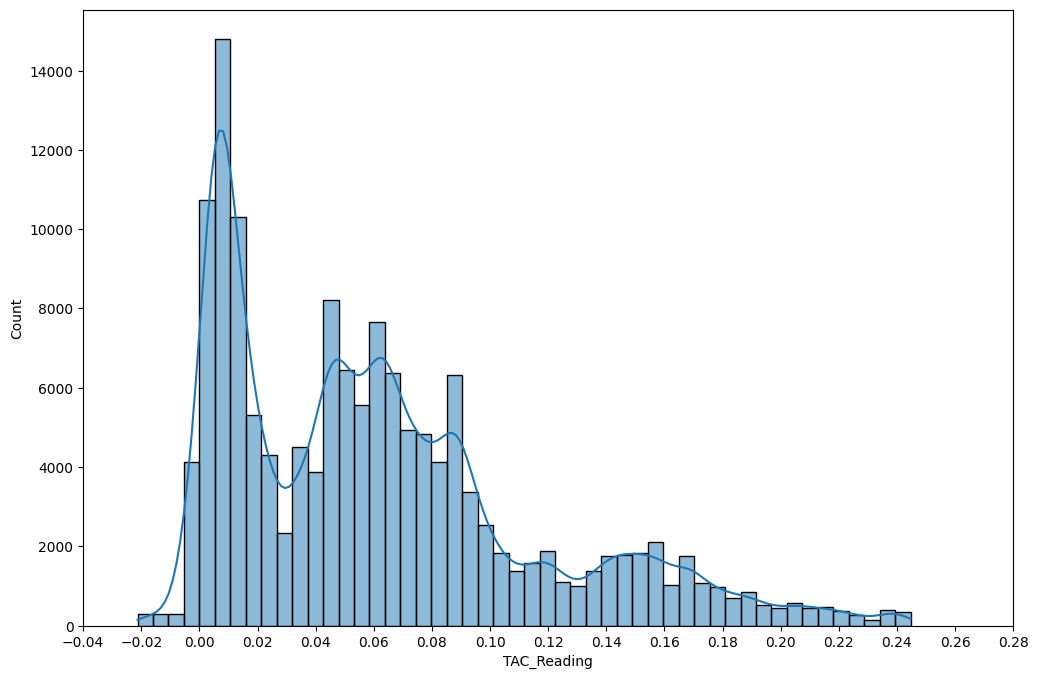

In [385]:
# plot distribution of TAC_Reading

plt.figure(figsize=(12, 8))
_ = sns.histplot(data=acc_tac, x='TAC_Reading', kde=True, bins=50)
_ = plt.xticks(np.arange(-0.04, 0.3, 0.02))


In [327]:
acc_tac

,pid,datetime,mean_x,mean_y,mean_z,std_x,std_y,std_z,min_x,min_y,...,max_y,max_z,mean_x_prev1,mean_x_prev2,mean_y_prev1,mean_y_prev2,mean_z_prev1,mean_z_prev2,timestamp,TAC_Reading
0,BK7610,2017-05-02 14:38:00,0.002410,0.003124,0.006632,0.019696,0.040272,0.038906,-0.0564,-0.1068,...,0.1408,0.1346,-0.002875,0.028505,0.006546,-0.002868,0.008528,0.010493,1.493736e+09,0.057005
1,BK7610,2017-05-02 14:38:05,0.001282,0.006086,0.006846,0.030217,0.045303,0.070110,-0.0975,-0.1560,...,0.1457,0.2335,0.002410,-0.002875,0.003124,0.006546,0.006632,0.008528,1.493736e+09,0.057041
2,BK7610,2017-05-02 14:38:10,0.001407,0.003756,0.008578,0.017237,0.016031,0.028314,-0.0465,-0.0832,...,0.0520,0.0935,0.001282,0.002410,0.006086,0.003124,0.006846,0.006632,1.493736e+09,0.057077
3,BK7610,2017-05-02 14:38:15,-0.000392,0.003903,0.010595,0.013915,0.018352,0.027769,-0.0569,-0.0716,...,0.0769,0.1354,0.001407,0.001282,0.003756,0.006086,0.008578,0.006846,1.493736e+09,0.057113
4,BK7610,2017-05-02 14:38:20,0.000646,0.001429,0.006806,0.015657,0.012607,0.021648,-0.0895,-0.0976,...,0.0412,0.0922,-0.000392,0.001407,0.003903,0.003756,0.010595,0.008578,1.493736e+09,0.057149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61294,SF3079,2017-05-03 03:32:10,0.010202,-0.012414,-0.000763,0.160639,0.127369,0.106741,-0.3685,-0.7707,...,0.2069,0.3127,0.019381,0.011826,-0.004944,0.028394,0.007839,0.003872,1.493782e+09,0.159551
61295,SF3079,2017-05-03 05:53:30,0.000045,-0.110500,0.084445,0.302868,0.494101,0.167153,-1.0867,-1.4333,...,0.8932,0.7113,0.010202,0.019381,-0.012414,-0.004944,-0.000763,0.007839,1.493791e+09,0.038294
61296,SF3079,2017-05-03 05:53:35,0.023698,-0.018570,-0.003995,0.034306,0.046022,0.010285,-0.0247,-0.2379,...,0.0292,0.0489,0.000045,0.010202,-0.110500,-0.012414,0.084445,-0.000763,1.493791e+09,0.038278
61297,SF3079,2017-05-03 05:53:40,0.002889,0.015602,-0.004387,0.090404,0.093487,0.088484,-0.9975,-0.3293,...,0.4716,0.4608,0.023698,0.000045,-0.018570,-0.110500,-0.003995,0.084445,1.493791e+09,0.038262


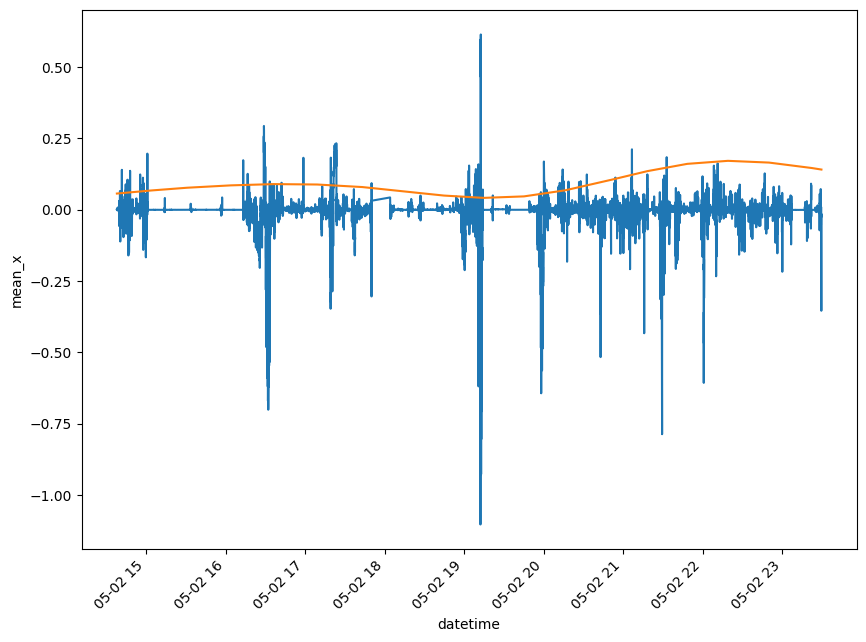

In [386]:
plt.figure(figsize=(10, 7))
sns.lineplot(data=acc_tac[acc_tac.pid=='BK7610'].reset_index(), x='datetime', y='mean_x')
sns.lineplot(data=acc_tac[acc_tac.pid=='BK7610'].reset_index(), x='datetime', y='TAC_Reading')
plt.xticks(rotation=45, ha='right')
plt.show()


In [387]:
acc_tac['day'] = acc_tac['datetime'].dt.day
acc_tac['hour'] = acc_tac['datetime'].dt.hour
acc_tac['minute'] = acc_tac['datetime'].dt.minute

acc_tac.head()

,pid,datetime,mean_x,mean_y,mean_z,mean_x_prev1,mean_x_prev2,mean_x_prev3,mean_x_prev4,mean_x_prev5,...,mean_z_prev1,mean_z_prev2,mean_z_prev3,mean_z_prev4,mean_z_prev5,timestamp,TAC_Reading,day,hour,minute
0,BK7610,2017-05-02 14:38:00,0.000240,0.003501,0.006988,0.000524,-0.000921,0.003851,0.004779,0.069006,...,0.006488,0.006705,0.022819,0.006020,0.003128,1.493736e+09,0.056998,2,14,38
1,BK7610,2017-05-02 14:38:02,-0.000251,0.003664,0.008094,0.000240,0.000524,-0.000921,0.003851,0.004779,...,0.006988,0.006488,0.006705,0.022819,0.006020,1.493736e+09,0.057012,2,14,38
2,BK7610,2017-05-02 14:38:04,0.004537,0.006506,0.005559,-0.000251,0.000240,0.000524,-0.000921,0.003851,...,0.008094,0.006988,0.006488,0.006705,0.022819,1.493736e+09,0.057027,2,14,38
3,BK7610,2017-05-02 14:38:06,0.001697,0.005113,0.006370,0.004537,-0.000251,0.000240,0.000524,-0.000921,...,0.005559,0.008094,0.006988,0.006488,0.006705,1.493736e+09,0.057041,2,14,38
4,BK7610,2017-05-02 14:38:08,0.003004,0.004241,0.006682,0.001697,0.004537,-0.000251,0.000240,0.000524,...,0.006370,0.005559,0.008094,0.006988,0.006488,1.493736e+09,0.057055,2,14,38


In [388]:
from sklearn.model_selection import train_test_split

data = acc_tac.drop(columns=['datetime', 'timestamp', 'pid'])

features = data.drop(columns=['TAC_Reading'])
target = data['TAC_Reading']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True)

In [395]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error


dt = DecisionTreeRegressor(max_depth=10, random_state=10)

dt.fit(X_train, y_train)

print("Decision Tree", "-"*50, sep='\n')

print("Train score: ", dt.score(X_train, y_train))
print("Test score: ", dt.score(X_test, y_test))

print("Train MSE", mean_squared_error(y_train, dt.predict(X_train)))
print("Test MSE", mean_squared_error(y_test, dt.predict(X_test)))

Decision Tree
--------------------------------------------------
Train score:  0.7542781948533829
Test score:  0.7062149077532769
Train MSE 0.000715581806363209
Test MSE 0.0008436752249704693


In [398]:
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

print("Random Forest", "-"*50, sep='\n')


print("Train r2: ", rf.score(X_train, y_train))
print("Test r2: ", rf.score(X_test, y_test))

print("Train MSE", mean_squared_error(y_train, rf.predict(X_train)))
print("Test MSE", mean_squared_error(y_test, rf.predict(X_test)))

Random Forest
--------------------------------------------------
Train r2:  0.8037232186664269
Test r2:  0.7694942969859834
Train MSE 0.0005715898662311631
Test MSE 0.0006619530942162563
